# scVI on C. elegans single cell RNA-seq data


Original paper on Science:  
`A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution`  
https://science.sciencemag.org/content/365/6459/eaax1971.long

Data was generated using 10x genomics v2 chemistry, described in this note:
https://teichlab.github.io/scg_lib_structs/data/CG000108_AssayConfiguration_SC3v2.pdf

Data on GEO:  
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954

Link to download formatted anndata file used here, `packer.h5ad` (648MB):  
https://github.com/Munfred/worm-notebooks/releases/download/Packer/packer.h5ad


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import GeneExpressionDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
import torch
import scanpy as sc
import anndata


[2019-11-17 16:08:38,036] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/Users/munfred/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [83]:
# Uncomment the line below to download the data to the current folder:
#! wget https://github.com/Munfred/worm-notebooks/releases/download/Packer/packer.h5ad

# Change the path where the models will be saved 
save_path = "./"


## Loading data

We load the anndata file which already contains the annotations from the paper.  
To learn more about anndata visit  
https://icb-anndata.readthedocs-hosted.com/en/stable/index.html


In [3]:
adata = anndata.read('packer.h5ad')

In [4]:
adata.X

<89701x20222 sparse matrix of type '<class 'numpy.float32'>'
	with 82802059 stored elements in Compressed Sparse Column format>

In [16]:
adata.var.index.values

array(['WBGene00010957', 'WBGene00010958', 'WBGene00010959', ...,
       'WBGene00021595', 'WBGene00021594', 'WBGene00007064'], dtype=object)

In [20]:
adata.obs['cell.type'].values

[Body_wall_muscle, nan, nan, Body_wall_muscle, Ciliated_amphid_neuron, ..., Rectal_gland, nan, nan, nan, nan]
Length: 89701
Categories (37, object): [ABarpaaa_lineage, Arcade_cell, Body_wall_muscle, Ciliated_amphid_neuron, ..., hmc_and_homolog, hmc_homolog, hyp1V_and_ant_arc_V, nan]

In [30]:
adata.obs['batch'].values

[Waterston_300_minutes, Waterston_300_minutes, Waterston_300_minutes, Waterston_300_minutes, Waterston_300_minutes, ..., Murray_b02, Murray_b02, Murray_b02, Murray_b02, Murray_b02]
Length: 89701
Categories (7, object): [Murray_b01, Murray_b02, Murray_r17, Waterston_300_minutes, Waterston_400_minutes, Waterston_500_minutes_batch_1, Waterston_500_minutes_batch_2]

In [29]:
adata.obs['batch'].cat.codes.values

array([3, 3, 3, ..., 1, 1, 1], dtype=int8)

In [14]:
adata.obs.head().T

index                                   AAACCTGAGACAATAC-300.1.1  \
cell                                    AAACCTGAGACAATAC-300.1.1   
n.umi                                                       1630   
time.point                                           300_minutes   
batch                                      Waterston_300_minutes   
Size_Factor                                              1.02319   
cell.type                                       Body_wall_muscle   
cell.subtype                                      BWM_head_row_1   
plot.cell.type                                    BWM_head_row_1   
raw.embryo.time                                              360   
embryo.time                                                  380   
embryo.time.bin                                          330-390   
raw.embryo.time.bin                                      330-390   
lineage                                                 MSxpappp   
passed_initial_QC_or_later_whitelisted                      True   

index                                   AAACCTGAGGGCTCTC-300.1.1  \
cell                                    AAACCTGAGGGCTCTC-300.1.1   
n.umi                                                       2319   
time.point                                           300_minutes   
batch                                      Waterston_300_minutes   
Size_Factor                                              1.45821   
cell.type                                                    nan   
cell.subtype                                                 nan   
plot.cell.type                                               nan   
raw.embryo.time                                              260   
embryo.time                                                  220   
embryo.time.bin                                          210-270   
raw.embryo.time.bin                                      210-270   
lineage                                                 MSxapaap   
passed_initial_QC_or_later_whitelisted                      True   

index                                   AAACCTGAGTGCGTGA-300.1.1  \
cell                                    AAACCTGAGTGCGTGA-300.1.1   
n.umi                                                       3719   
time.point                                           300_minutes   
batch                                      Waterston_300_minutes   
Size_Factor                                              2.33828   
cell.type                                                    nan   
cell.subtype                                                 nan   
plot.cell.type                                               nan   
raw.embryo.time                                              270   
embryo.time                                                  230   
embryo.time.bin                                          210-270   
raw.embryo.time.bin                                      270-330   
lineage                                                      nan   
passed_initial_QC_or_later_whitelisted                      True   

index                                   AAACCTGAGTTGAGTA-300.1.1  \
cell                                    AAACCTGAGTTGAGTA-300.1.1   
n.umi                                                       4251   
time.point                                           300_minutes   
batch                                      Waterston_300_minutes   
Size_Factor                                              2.65905   
cell.type                                       Body_wall_muscle   
cell.subtype                                        BWM_anterior   
plot.cell.type                                      BWM_anterior   
raw.embryo.time                                              260   
embryo.time                                                  280   
embryo.time.bin                                          270-330   
raw.embryo.time.bin                                      210-270   
lineage                                              

In [43]:
gene_dataset = GeneExpressionDataset()

gene_dataset.populate_from_data(
            adata.X,
            gene_names=adata.var.index.values,
            cell_types=adata.obs['cell.type'].values,
            batch_indices=adata.obs['batch'].cat.codes.values,
            )

# We select the 1000 most variable genes, which is the default selection criteria of scvi
gene_dataset.subsample_genes(1000)
sel_genes = gene_dataset.gene_names


[2019-11-17 16:44:36,444] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
INFO:scvi.dataset.dataset:Remapping labels to [0,N]
[2019-11-17 16:44:36,448] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]
[2019-11-17 16:44:37,966] INFO - scvi.dataset.dataset | Downsampling from 20222 to 1000 genes
INFO:scvi.dataset.dataset:Downsampling from 20222 to 1000 genes
[2019-11-17 16:44:38,010] INFO - scvi.dataset.dataset | Computing the library size for the new data
INFO:scvi.dataset.dataset:Computing the library size for the new data
[2019-11-17 16:44:38,393] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
INFO:scvi.dataset.dataset:Filtering non-expressing cells.
[2019-11-17 16:44:38,597] INFO - scvi.dataset.dataset | Computing the library size for the new data
INFO:scvi.dataset.dataset:Computing the library size for the new data
[2019-11-17 16:44:38,973] INFO - scvi.dataset.dataset | Downsampled from 8

## Training

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 

10 epochs is usually sufficient for exploratory analysis

In [44]:
n_epochs = 10 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_cuda = False

- We now create the model and the trainer object. 
- We train the model and output model likelihood every 1 epochs.
- In order to evaluate the likelihood on a test set, we split the datasets (the current code can also so train/validation/test).

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. 

In [45]:
vae = VAE(gene_dataset.nb_genes, 
          n_batch=len(adata.obs['batch'].unique())
         )

trainer = UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=1,
)

if os.path.isfile('%s/vae.pkl' % save_path):
    trainer.model.load_state_dict(torch.load('%s/vae.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/vae.pkl' % save_path)

training: 100%|██████████| 50/50 [1:04:27<00:00, 77.35s/it]


**Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

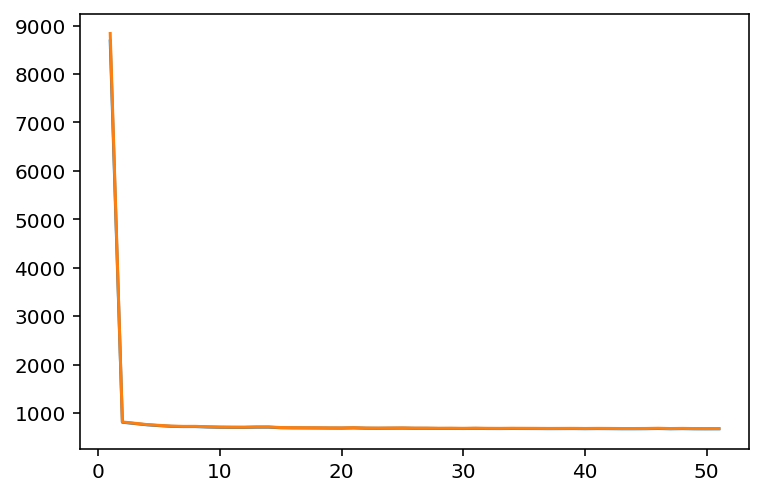

In [46]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(1, len(elbo_train_set), (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
# plt.yscale('log')
# plt.ylim(1150, 1600)
plt.show()

## Visualizing the latent space with UMAP

In [51]:
post_adata = anndata.AnnData(X=gene_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs = adata.obs


In [52]:
post_adata

AnnData object with n_obs × n_vars = 89701 × 1000 
    obs: 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted'
    obsm: 'X_scVI'

In [53]:
post_adata.obs['cell.type']

index
AAACCTGAGACAATAC-300.1.1          Body_wall_muscle
AAACCTGAGGGCTCTC-300.1.1                       nan
AAACCTGAGTGCGTGA-300.1.1                       nan
AAACCTGAGTTGAGTA-300.1.1          Body_wall_muscle
AAACCTGCAAGACGTG-300.1.1    Ciliated_amphid_neuron
                                     ...          
TCTGAGACATGTCGAT-b02                  Rectal_gland
TCTGAGACATGTCTCC-b02                           nan
TGGCCAGCACGAAGCA-b02                           nan
TGGCGCACAGGCAGTA-b02                           nan
TGGGCGTTCAGGCCCA-b02                           nan
Name: cell.type, Length: 89701, dtype: category
Categories (37, object): [ABarpaaa_lineage, Arcade_cell, Body_wall_muscle, Ciliated_amphid_neuron, ..., hmc_and_homolog, hmc_homolog, hyp1V_and_ant_arc_V, nan]

In [54]:
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

/Users/munfred/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/munfred/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/lib/python3.7/site-packages/umap/utils.py", line 409:
@n

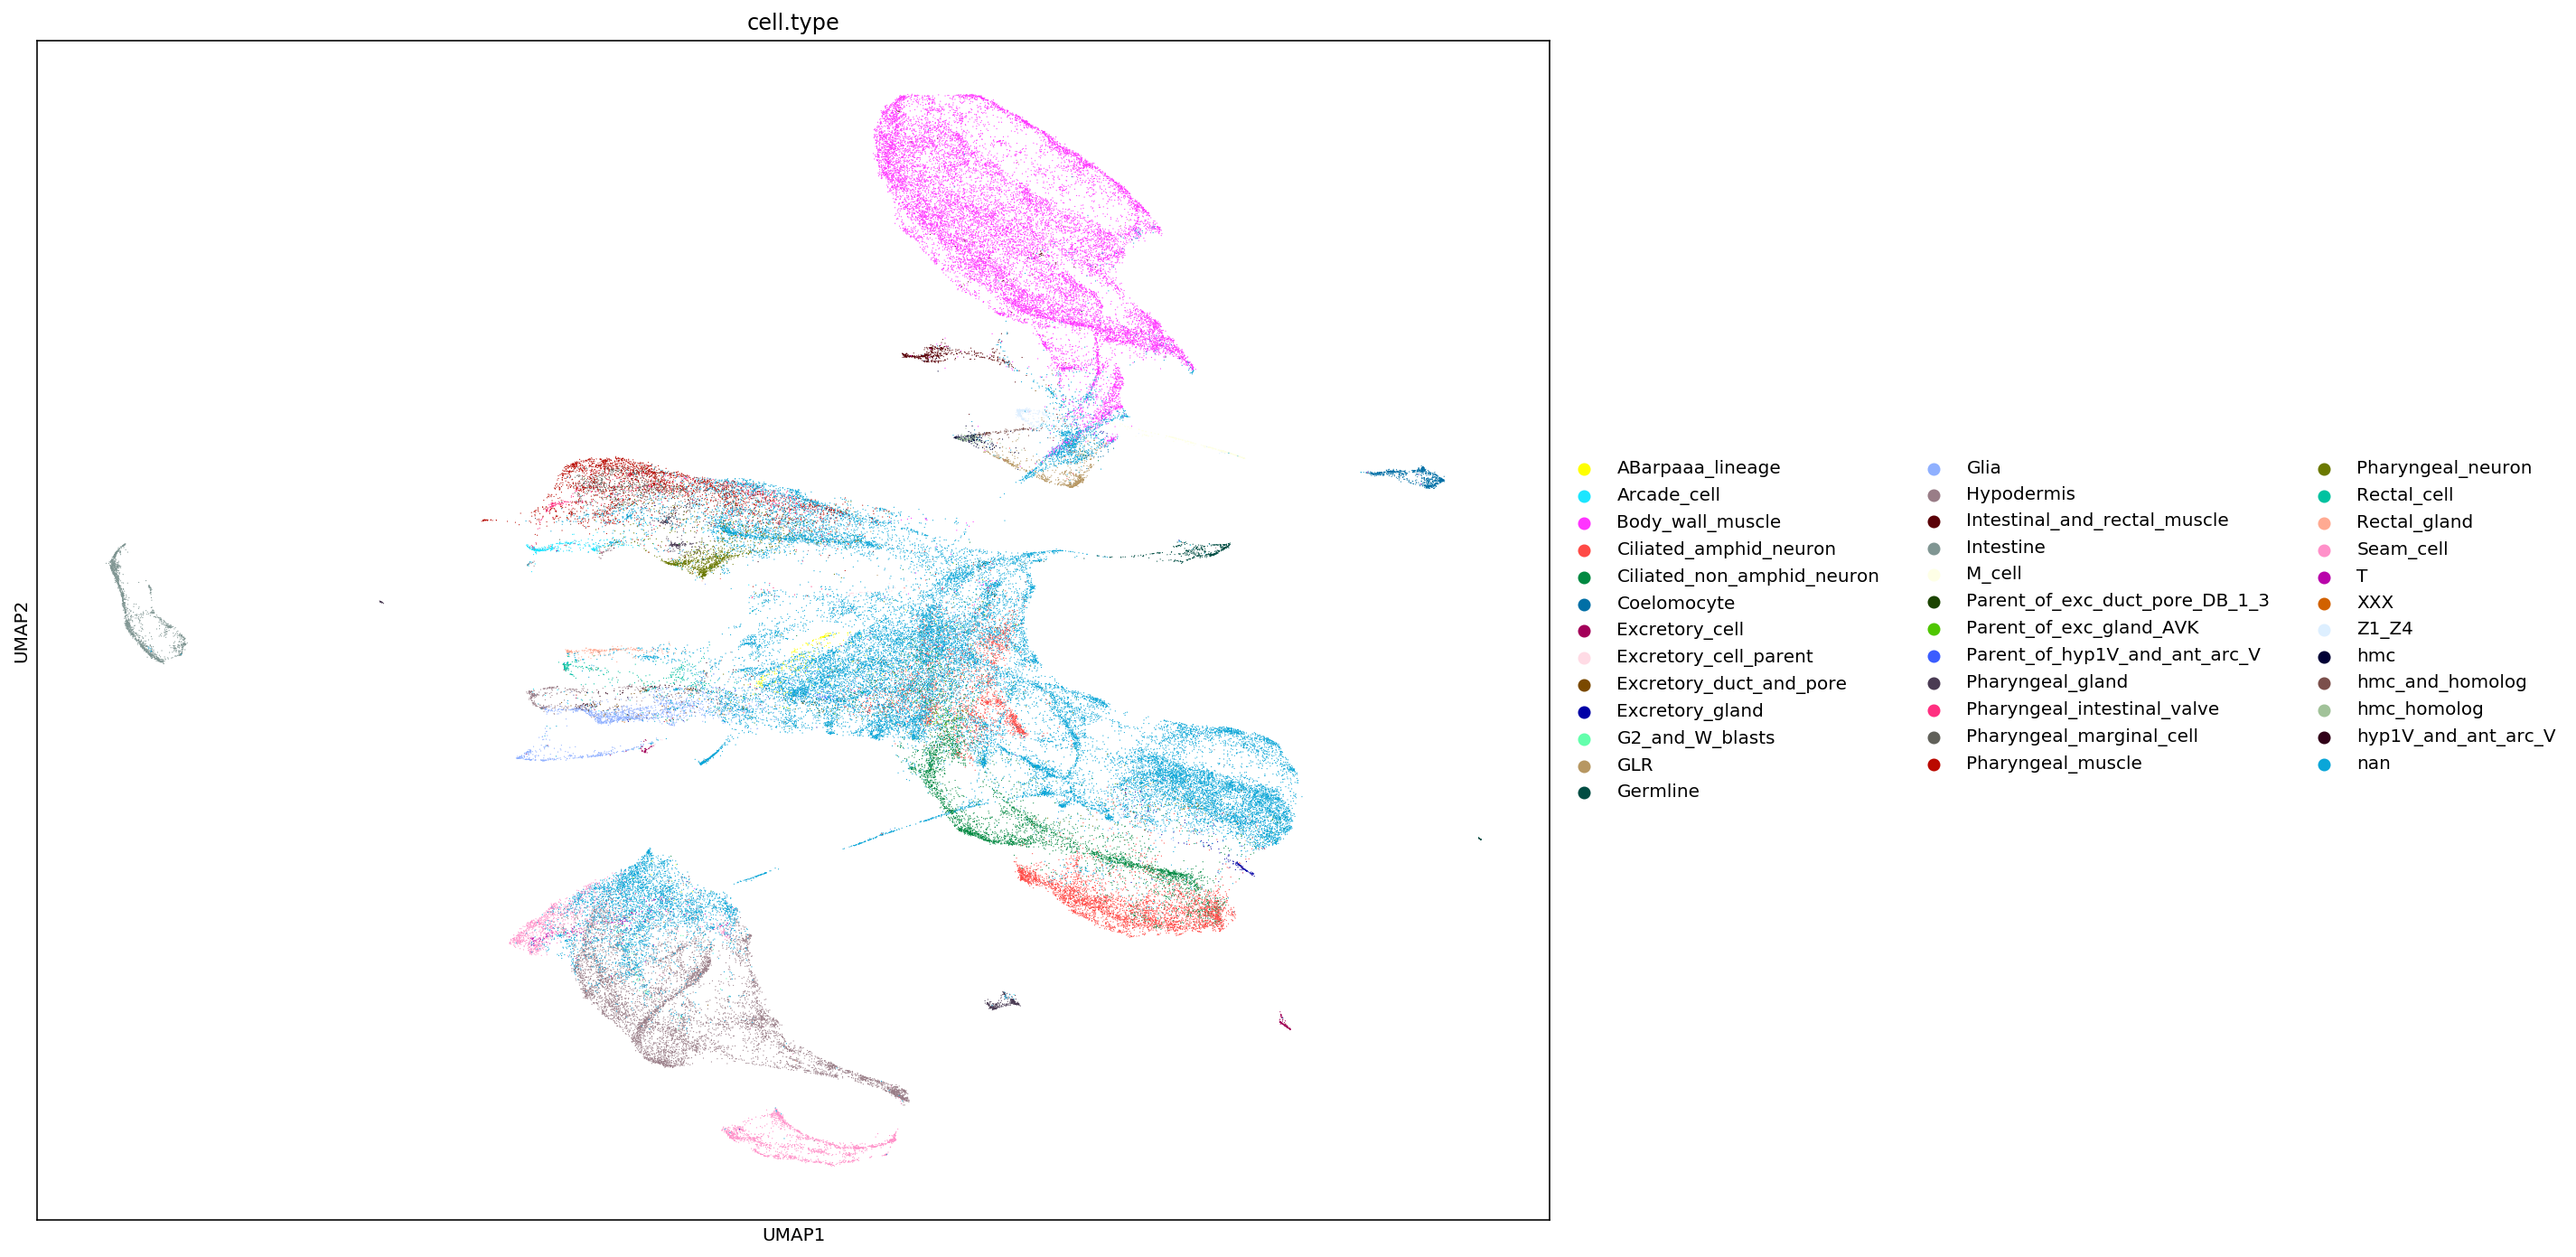

In [55]:
fig, ax = plt.subplots(figsize=(15, 12))
sc.pl.umap(post_adata, color=["cell.type"], ax=ax, show=show_plot)

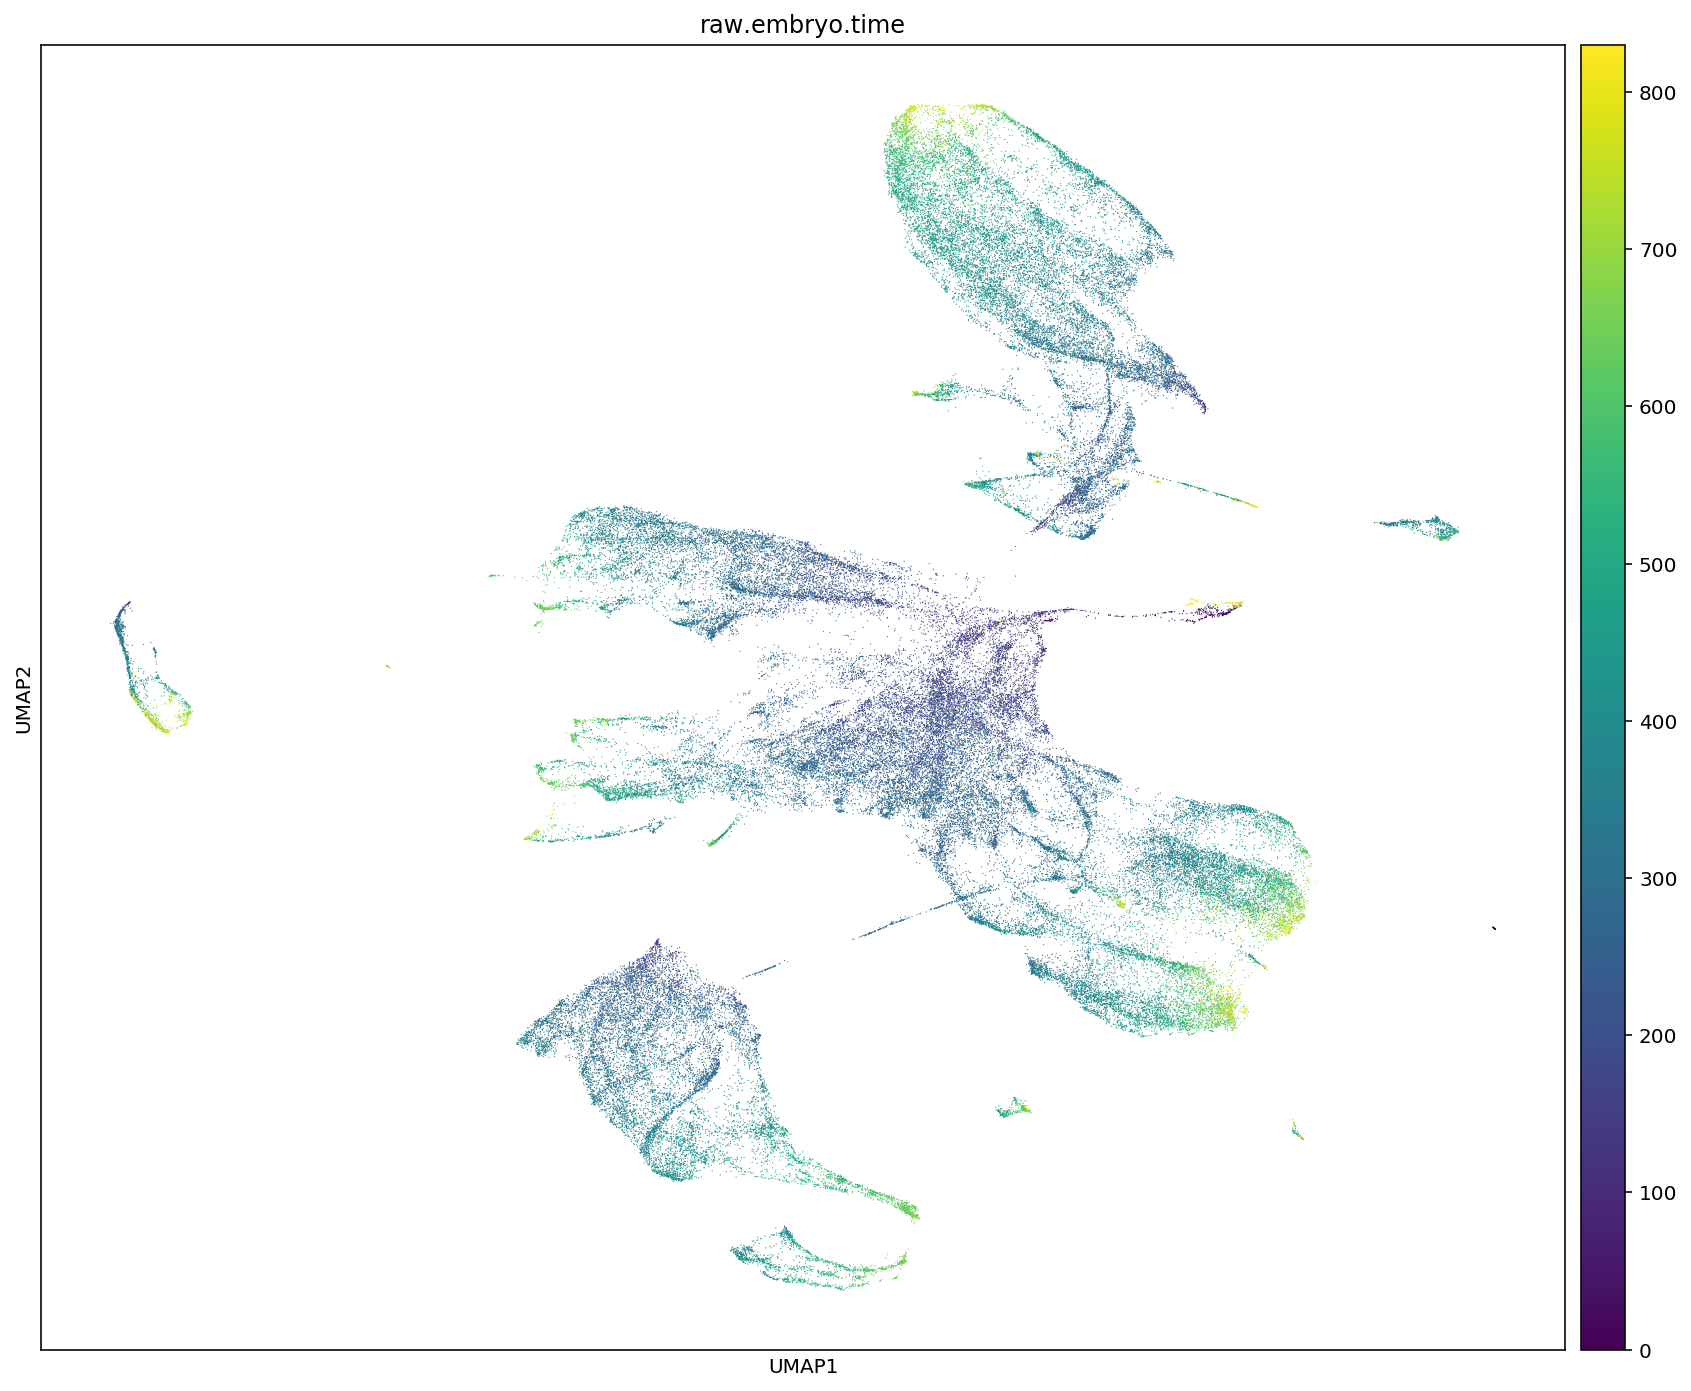

In [57]:
fig, ax = plt.subplots(figsize=(15, 12))
sc.pl.umap(post_adata, color=["raw.embryo.time"], ax=ax, show=show_plot)

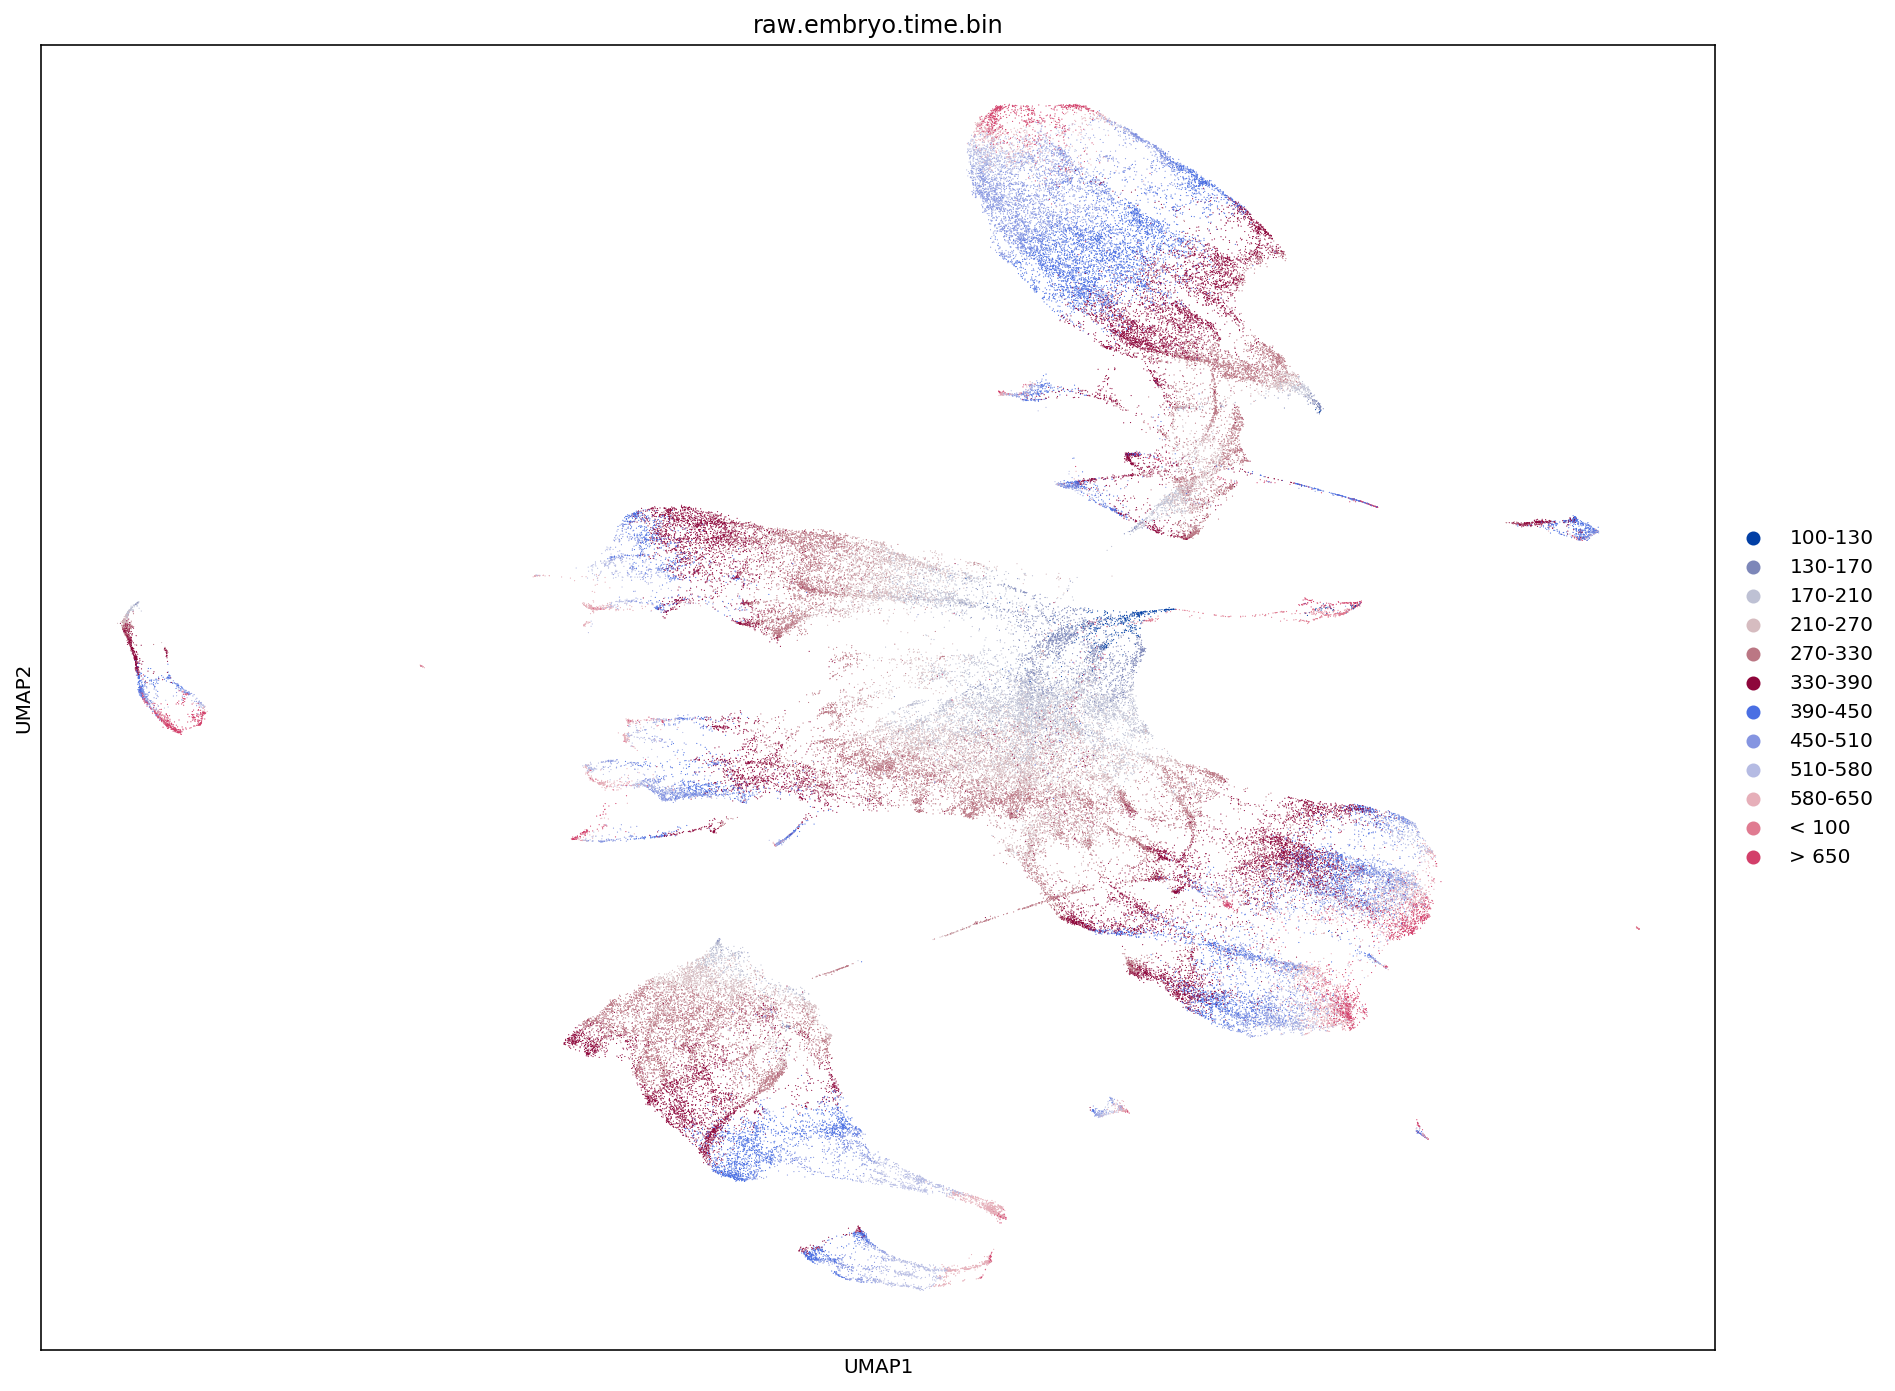

In [76]:
fig, ax = plt.subplots(figsize=(15, 12))
sc.pl.umap(post_adata, color=["raw.embryo.time.bin"], ax=ax, show=show_plot)

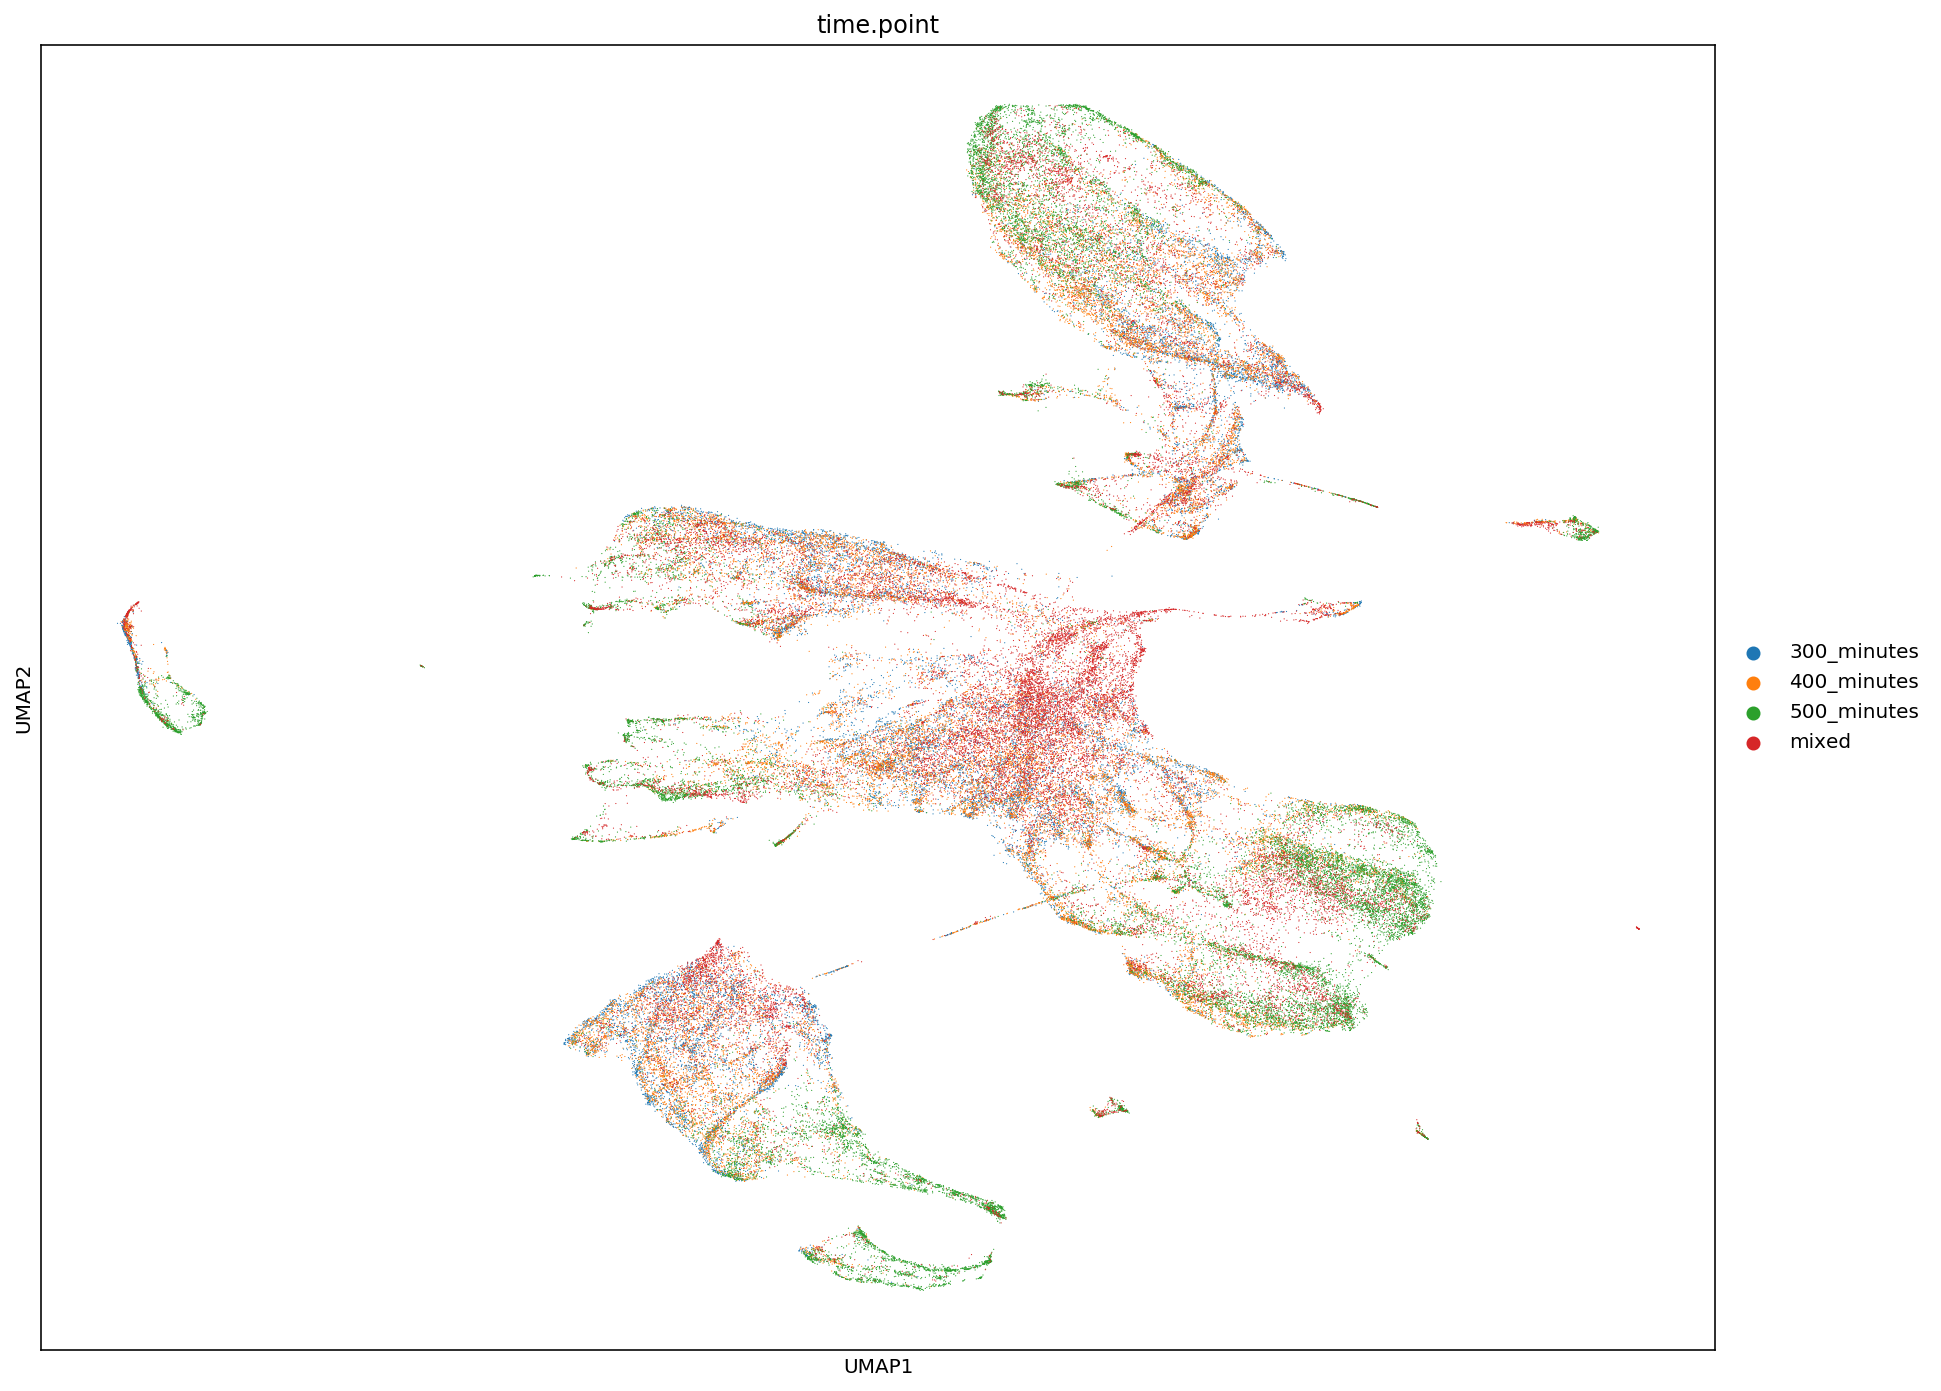

In [58]:
fig, ax = plt.subplots(figsize=(15, 12))
sc.pl.umap(post_adata, color=["time.point"], ax=ax, show=show_plot)

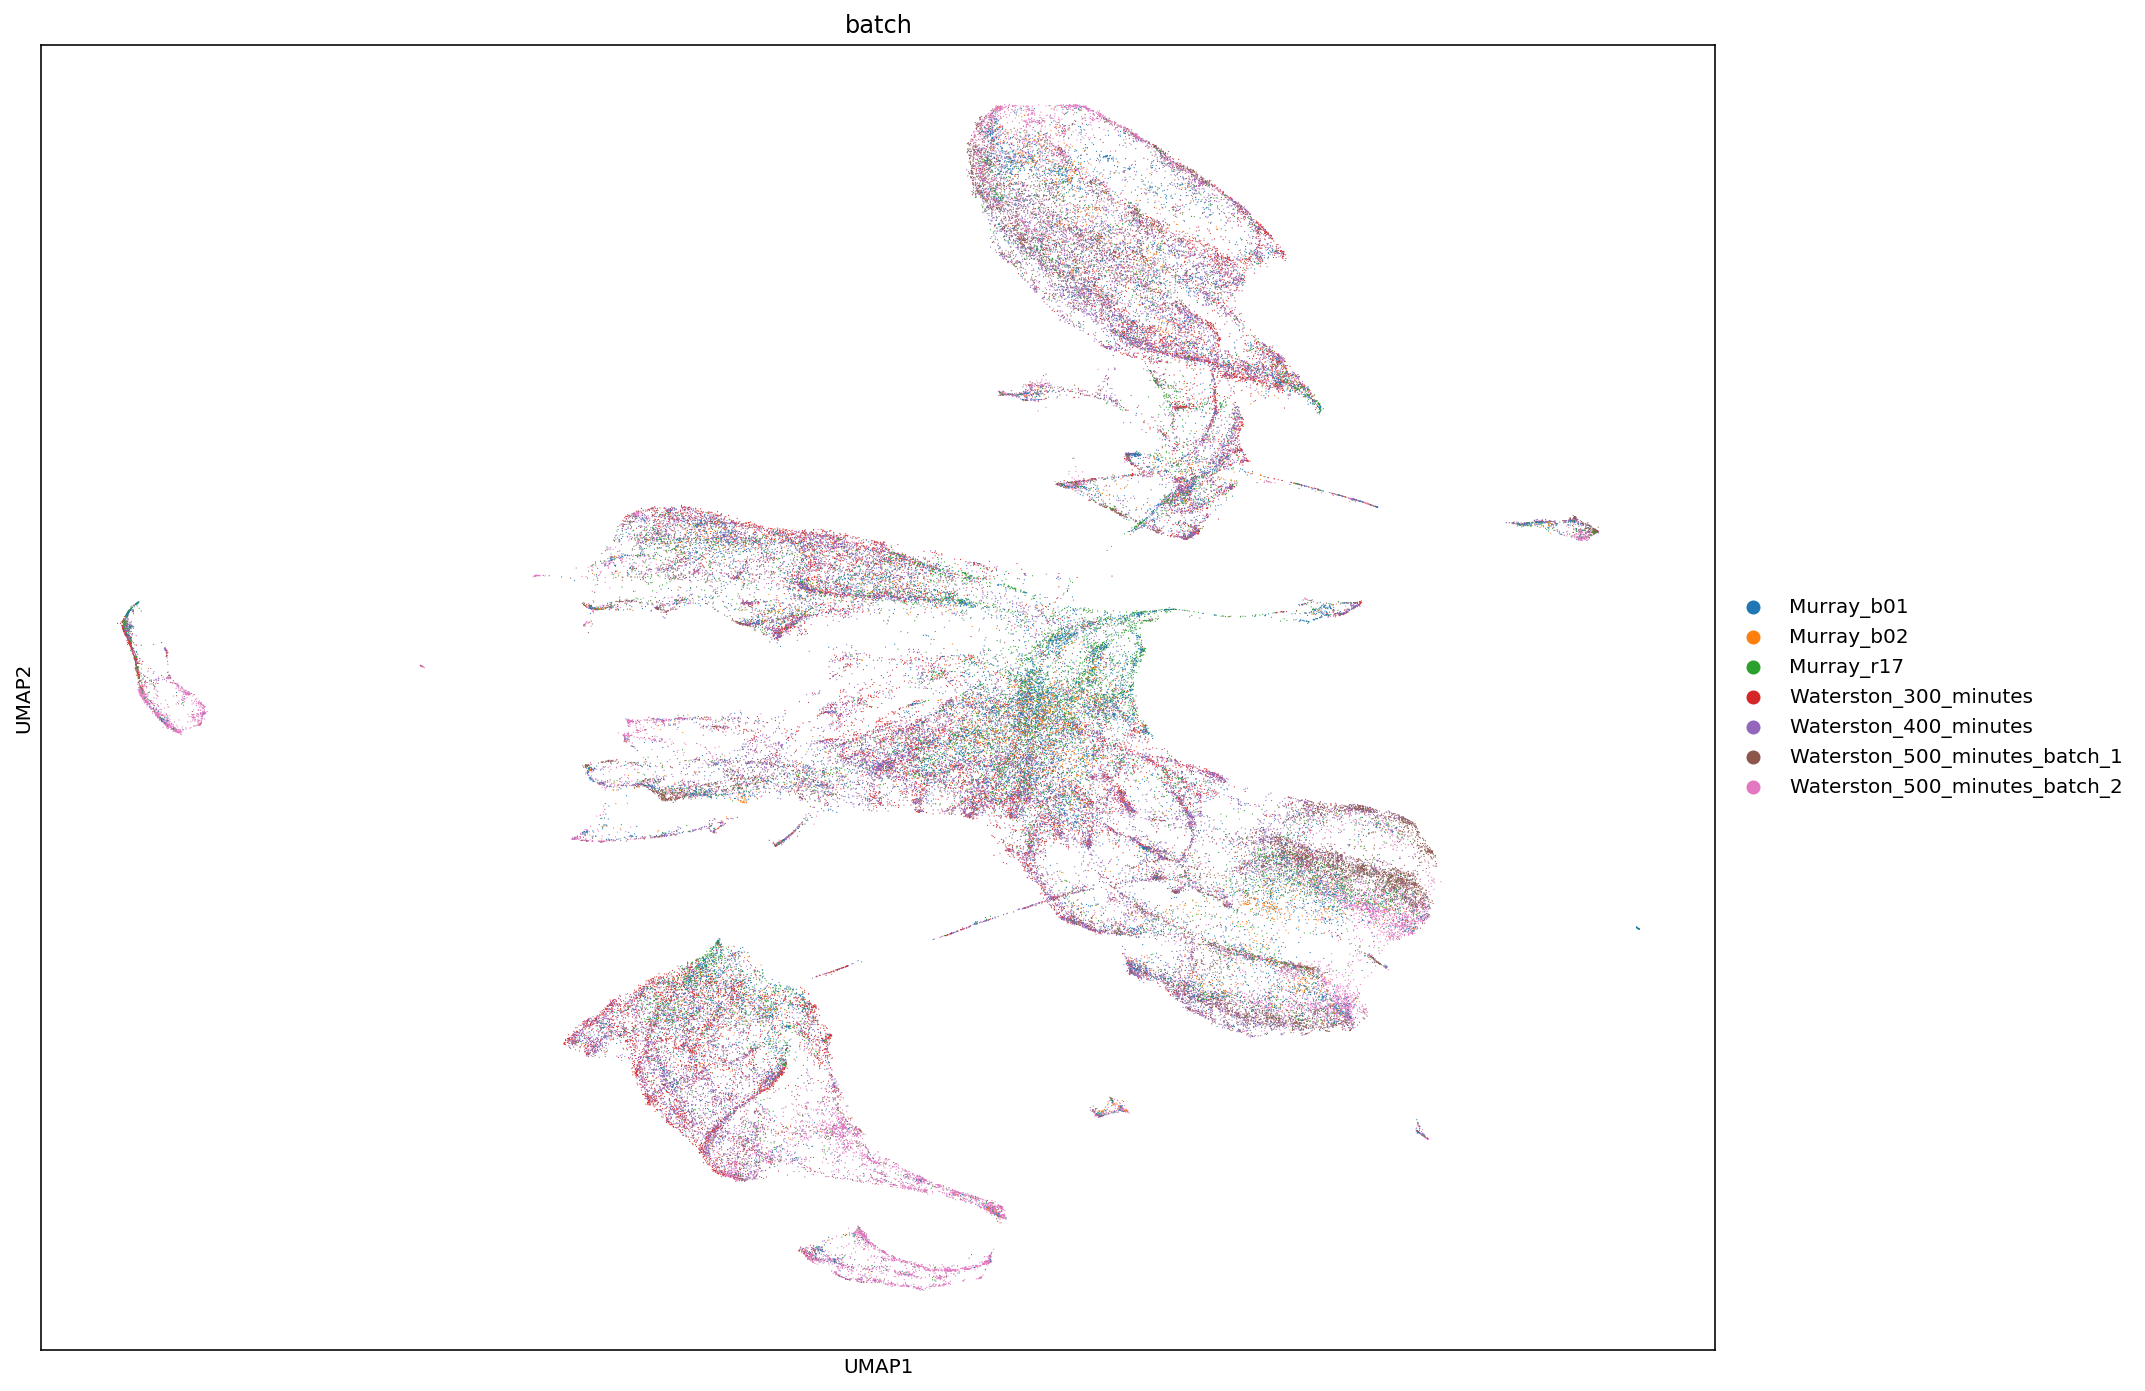

In [59]:
fig, ax = plt.subplots(figsize=(15, 12))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

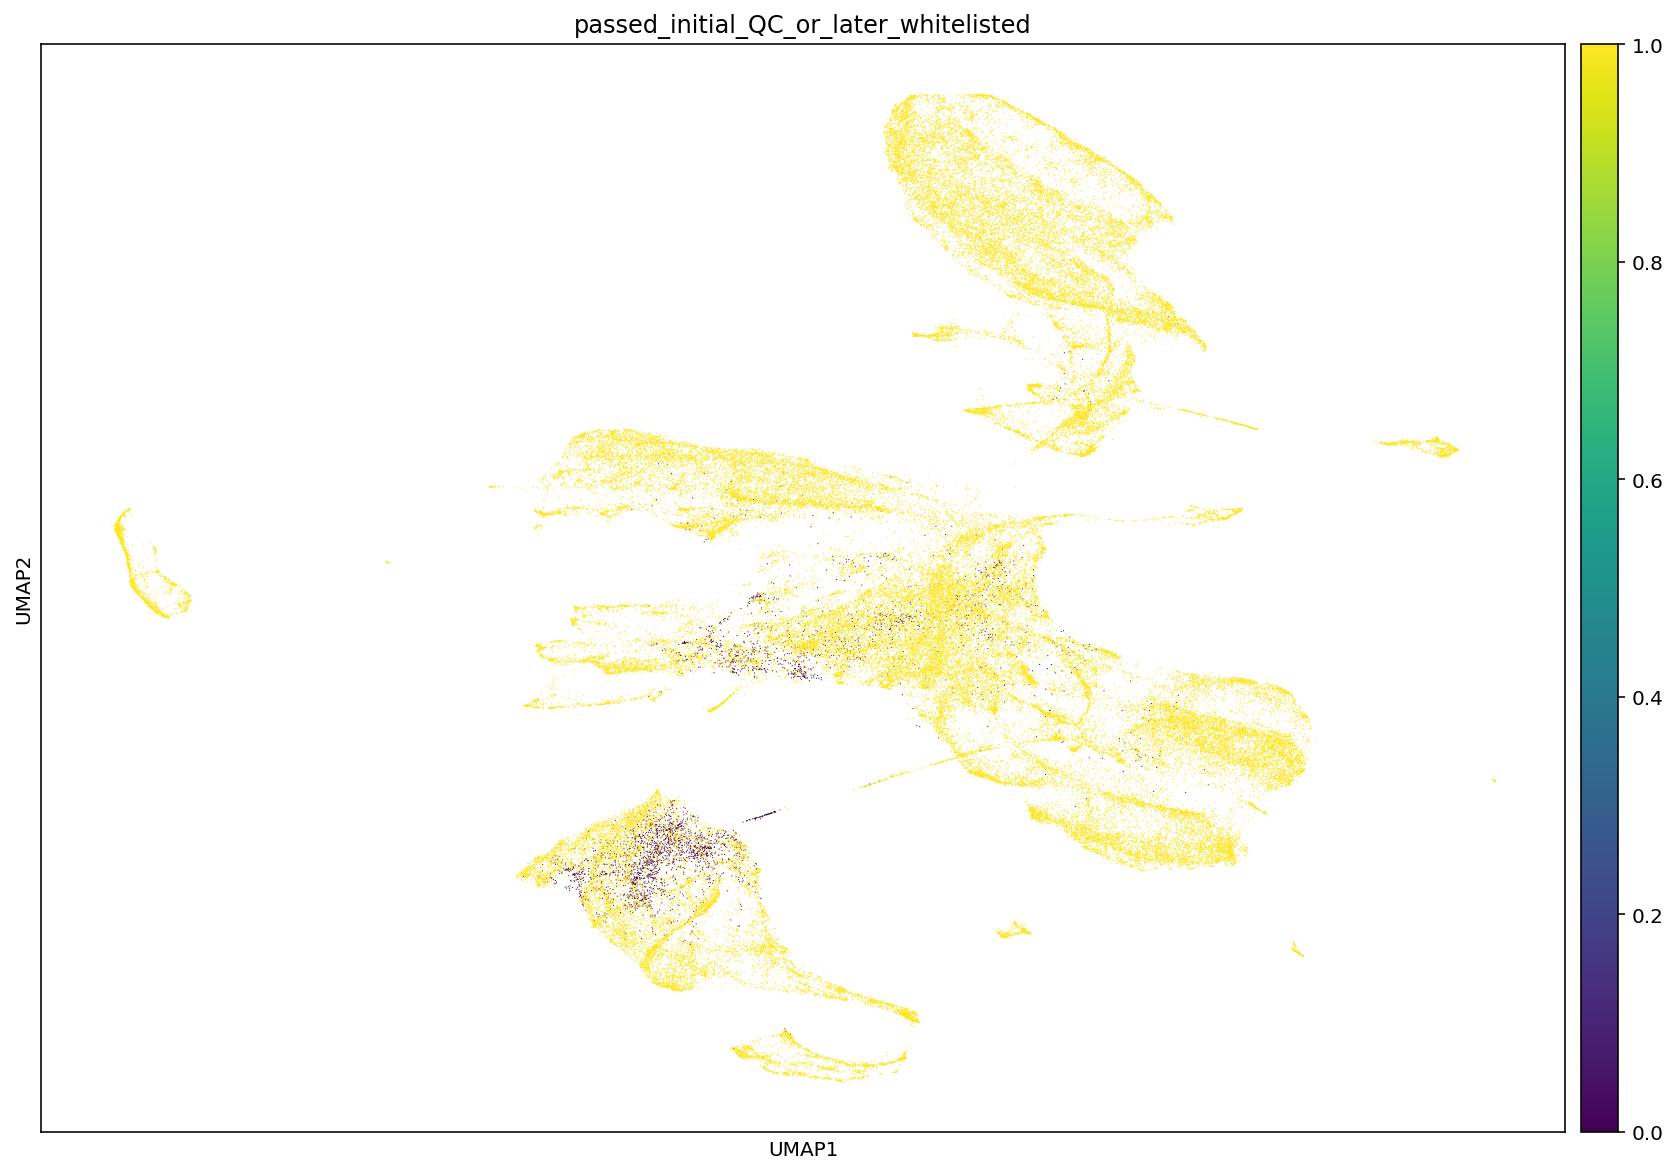

In [79]:
fig, ax = plt.subplots(figsize=(15, 10))
sc.pl.umap(post_adata, color=["passed_initial_QC_or_later_whitelisted"], ax=ax, show=show_plot)